In [1]:
%matplotlib notebook

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
base_dir = '/local/scratch/toolkit/'
os.environ['EXOT_ACCESS_DIR'] = str(base_dir + "benchmark_platforms_access/")
os.chdir(base_dir + 'datapro')
print("Working directory: " + str(os.getcwd()))
print("Key directory set to: " + str(os.environ['EXOT_ACCESS_DIR']))

Working directory: /local/scratch/toolkit/datapro
Key directory set to: /local/scratch/toolkit/benchmark_platforms_access/


In [4]:
np.set_printoptions(linewidth=120)
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams["legend.loc"] = "lower right"

import toml    as TOML              # TOML library to handle config files
import pandas  as pd                # Pandas for data manipulation
import seaborn as sb                # Statistical data visualisation
import pathlib as PATH              # Used to convert strings to path objects for (de-)serialisation
import types   as tp                # Library used for online method development

# scikit-learn packets
import sklearn.base                 #
import sklearn.svm                  # LinearSVC, SVC
import sklearn.pipeline             # make_pipeline
import sklearn.preprocessing        # StandardScaler
import sklearn.decomposition        # PCA
import sklearn.naive_bayes          # GaussianNB
import sklearn.metrics              # CM

# Toolkit packets
import exot                       # Dataprocessing
import exot.experiment            # Experiment for execution
import exot.util                  # General utilities
import exot.layer                 # Data manipulation layers
from exot.util       import *
from exot.layer      import *
from exot.channel    import *
from exot.experiment import *

# Plotting
from exot.plotting.experiment_plotter import *
from exot.plotting.run_plotter        import *\

# AttributeDict
from exot.util.attributedict import AttributeDict, LabelMapping

Tensorflow not available - excluding packets relying on it!


# Generate Experiment
#### 1. Load config

In [5]:
config = TOML.load("./configurations/thermal-cc_all_temperatures.toml")
print(TOML.dumps(config))

name = "thermal-cc_all_temperatures"
save_path = "./data"
backup_path = "./data/_backup"
experiment_exists_action = "update"

[EXPERIMENT]
type = "ExploratoryExperiment"
channel = "ThermalCC"

[EXPERIMENT.PHASES]

[EXPERIMENT.GENERAL]
latency = 10
fan = true
governors = "userspace"
frequencies = "max"
sampling_period = 0.001
delay_after_spawn = 150.0
delay_after_auxiliary = 1.0
active_wait = false

[EXPERIMENT.LAYERS.io]
name = "TimeValue"

[EXPERIMENT.GENERAL.ARMv8]
delay_after_spawn = 120.0
sampling_period = 0.005

[EXPERIMENT.GENERAL.ARMv7]
delay_after_spawn = 120.0
sampling_period = 0.005

[EXPERIMENT.LAYERS.io.params]
timebase = "ns"

[ENVIRONMENTS.Haswell.APPS.snk]
executable = "meter_thermal_msr"
zone = "host"

[ENVIRONMENTS.Haswell.APPS.src]
executable = "generator_utilisation_mt"
zone = "host"

[ENVIRONMENTS.Haswell.src.generator]
host_pinning = 0
should_pin_host = true
cores = [ 5,]
host_policy = "round_robin"
host_priority = 99
worker_priority = 98
worker_policy = "round_rob

#### 2a Instantiate an experiment

Experiment factory will take the type and channel from the config.

In [6]:
channel    = ChannelFactory()(config["EXPERIMENT"]["channel"])
experiment = ExperimentFactory()(config["EXPERIMENT"]["type"], config=config, channel=channel)

2020-04-28 15:21:42 :: bootstrapped layer 'io' with TimeValue


#### 2b Define the phase traces (rdpstreams)
For the exploratory experiments, the user can freely design his own traces, in the form of rdpstreams. Those streams are added to the experiment config and used to instantiate the runs.
The rdpstreams will be deleted from the config during the generation process, to make sure that the serialised experiment does not get too big.

In [7]:
duration_s = [
    0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.500, 0.500,
    0.250, 0.250, 0.250, 0.250, 0.250, 0.250, 0.250, 0.250, 
    0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125
] 

cores_t440p  = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
cores_odroid = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
cores_tegra  = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]
cores_xeon   = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0]

In [8]:
rdp_signals = [
                  pd.DataFrame(
                      # 10 periods of a rectangular waveform with 1Hz
                      data=np.transpose(np.vstack([duration_s, cores_t440p, cores_odroid, cores_tegra, cores_xeon])), 
                      columns=['timestamp', 't440p', 'odroid', 'tegraTX2', 'xeon']
                  )
              ]
experiment.config.EXPERIMENT.PHASES = AttributeDict.from_dict(
    {'range':{'rdpstreams':rdp_signals,'repetitions':1}}
)

#### 2 Generate the experiment

In [9]:
experiment.generate()
experiment.print_duration()

2020-04-28 15:21:45 :: Estimated duration of a single repetition of the range phase is 0:02:38
2020-04-28 15:21:45 :: This results in a total estimated duration of 0:02:38 for all repetitions.


#### 3. Write

Writes to disk, serialises the experiment, runs, and all streams.

In [10]:
experiment.write()

## Execute

Running `execute` will execute in all environments present in the configuration.

In [11]:
for env in [
            "ARMv7", 
            "ARMv8",
            "Haswell",
            "Sandy"
           ]:
    experiment.execute_in_environment(env, ["range"])

2020-04-02 16:58:05 :: executing phases: ['range'] in env 'ARMv7'
2020-04-02 16:58:08 :: ARMv7->bigLITTLE: connected: SSHUnixDriver
2020-04-02 16:58:08 :: ARMv7->bigLITTLE: sending experiment
2020-04-02 16:58:09 :: ARMv7->bigLITTLE: experiment sent!
2020-04-02 16:58:09 :: ARMv7->bigLITTLE: configuring to {'latency': 10, 'fan': True, 'governors': 'userspace', 'frequencies': 'max', 'sampling_period': 0.005, 'delay_after_spawn': 120.0, 'delay_after_auxiliary': 1.0, 'active_wait': False, 'ARMv8': {'delay_after_spawn': 120.0}}
2020-04-02 16:58:18 :: executing in env: 'ARMv7', resume: False, reps: [0], run: <Run at 0x7f5fa0141550 (digested, config={'phase': 'range', 'rdpstream_id': 0, 'repetitions': 1})>
2020-04-02 16:58:18 :: executing in env: ARMv7, rep: 0, estimated duration: 7.0s, run: <Run at 0x7f5fa0141550 (digested, config={'phase': 'range', 'rdpstream_id': 0, 'repetitions': 1})>
2020-04-02 17:00:34 :: ARMv7->bigLITTLE: experiment logs fetched!
2020-04-02 17:00:34 :: ARMv7->bigLITTLE:

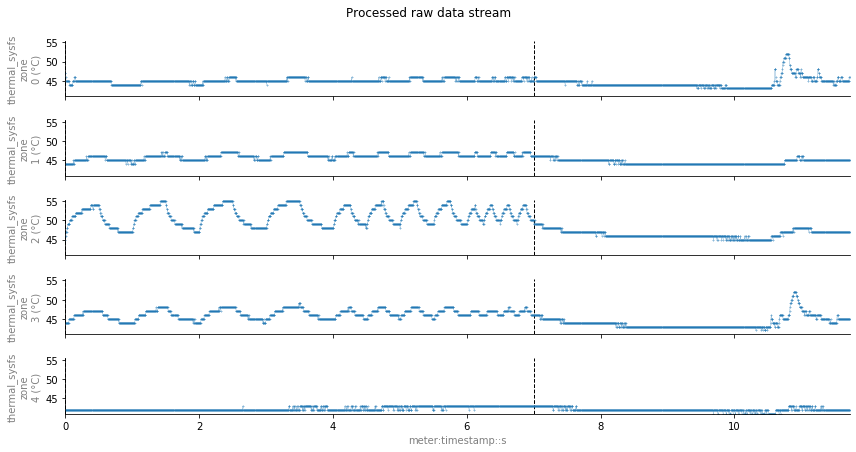

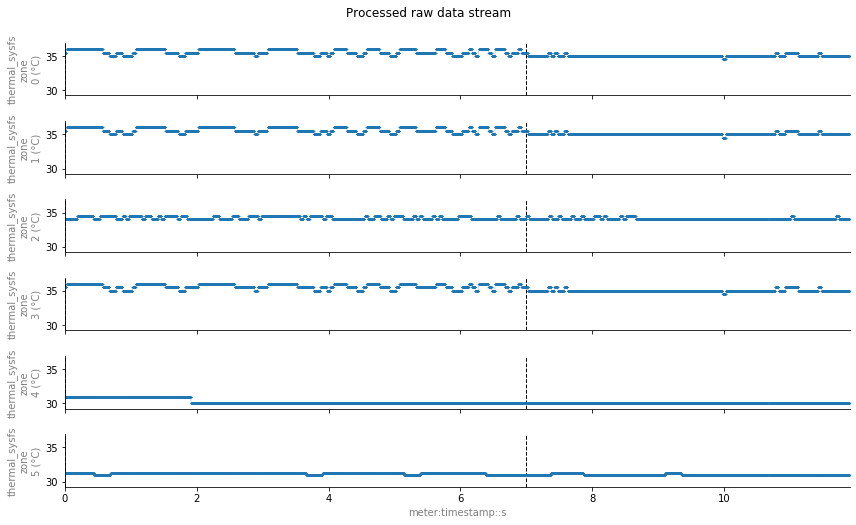

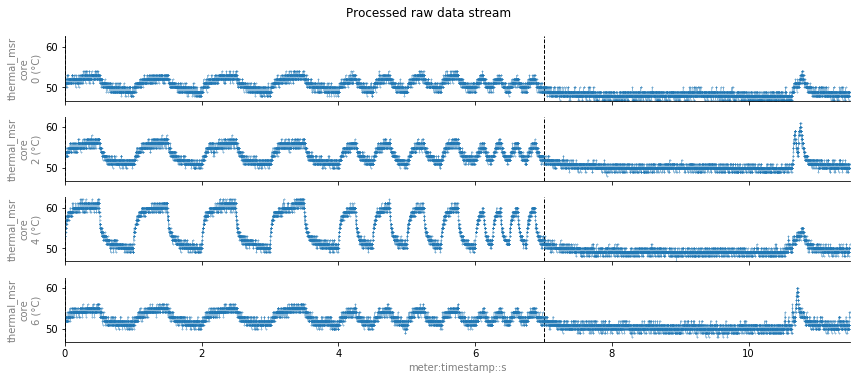

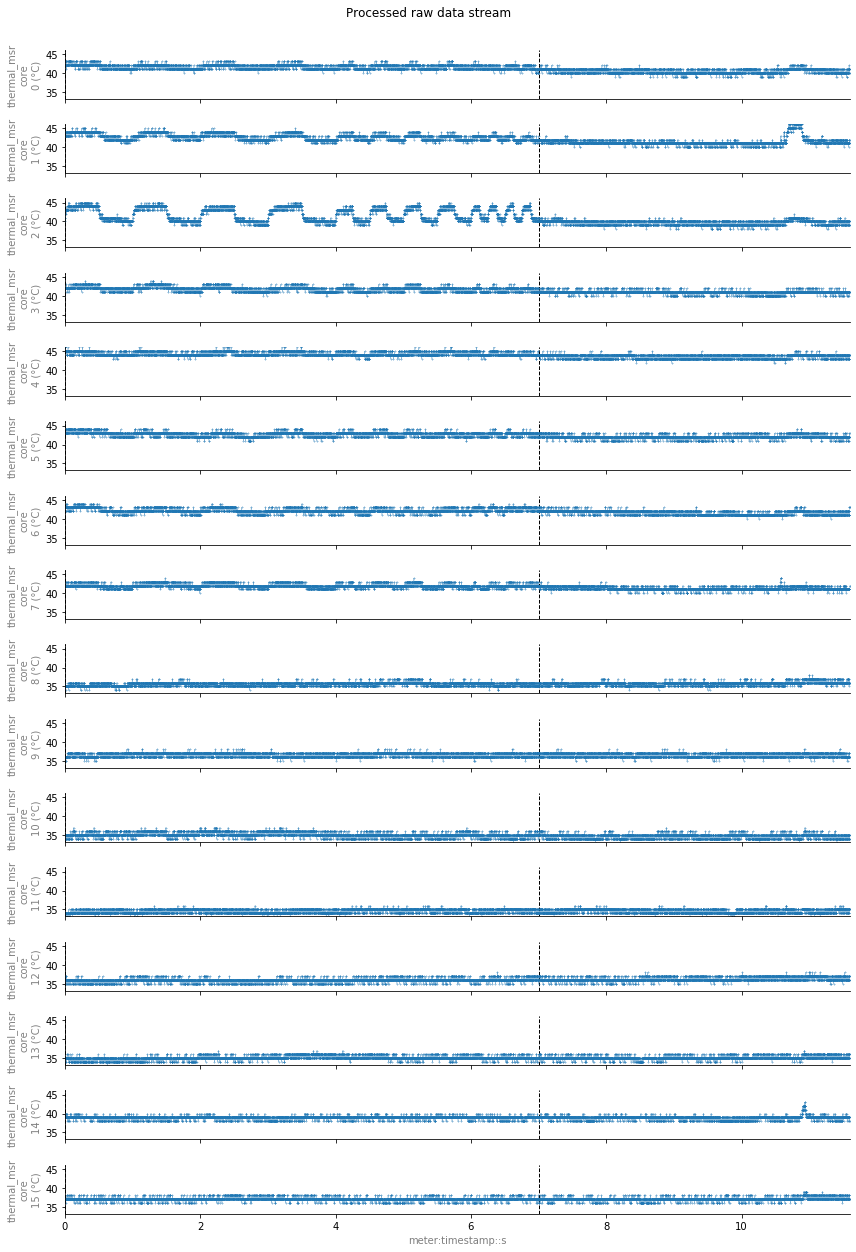

In [12]:
import scipy.interpolate

temperature_range_run = experiment.phases['range'][0]

ideal_timestamps = np.hstack([[0],np.cumsum(temperature_range_run.o_rdpstream.iloc[:,0]).to_numpy()])
ideal_values     = np.hstack([[temperature_range_run.o_rdpstream.iloc[0,1]], temperature_range_run.o_rdpstream.iloc[:,1].to_numpy()])
resampled_ideal_timestamps = np.arange(ideal_timestamps[0], ideal_timestamps[-1], 1/1000)
ideal_values_interpolator  = scipy.interpolate.interp1d(
    ideal_timestamps,
    ideal_values,
    axis=0,
    kind='next',
    bounds_error=False,
    fill_value="extrapolate",
)

resampled_ideal_values = ideal_values_interpolator(resampled_ideal_timestamps)

pd.DataFrame({'timestamps:s':resampled_ideal_timestamps, 'on/off':resampled_ideal_values}).to_csv(
            experiment.path.joinpath("temp_all_cores_input.dat"),
            sep=",",
            encoding="utf-8",
            index=False,
        )

for env in [
            "ARMv7", 
            "ARMv8",
            "Haswell",
            "Sandy"
           ]:
    if "ARM" in env:
        cores   = experiment.config.ENVIRONMENTS[env].snk.thermal_sysfs.zones
        matcher = exot.util.wrangle.Matcher("thermal", "sysfs", ["zone"], cores)
    else:
        cores   = experiment.config.ENVIRONMENTS[env].snk.thermal_msr.cores
        matcher = exot.util.wrangle.Matcher("thermal", "msr", ["core"], cores)
    ingest_args = dict(
        io={
               "env": env,
               "rep": 0,
               "matcher": [(matcher, None)]
           },
    )
    temperature_range_run.ingest(**ingest_args)
    max_idx = np.where(temperature_range_run.i_rdpstream.iloc[:,0] >= resampled_ideal_timestamps[-1])[0][0]+1
    
    temperature_range_run.i_rdpstream.iloc[:max_idx,:].to_csv(
            experiment.path.joinpath("temp_all_cores_{}.dat".format(env)),
            sep=",",
            encoding="utf-8",
            index=False,
        )
        
    with RunPlotter(temperature_range_run) as plotter:
        plotter.plot_rdpstream()